<a href="https://colab.research.google.com/github/gauravg1109/Anomaly-Detection/blob/main/Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gauravg12345","key":"23c7ec56627bce15c3c6f9fd4f85b025"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                        title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                             Apple Quality                                       170KB  2024-01-11 14:31:07          18805        415  1.0              
mikhail1681/walmart-sales                                  Walmart Sales                                       122KB  2024-02-13 17:35:56           2231         41  1.0              
kapoorprakhar/college-placement-dataset                    College Placement Dataset                            324B  2024-02-15 18:27:29           1661         36  1.0              
nelgiriyewithana/emotions                                  Emotions                  

In [ ]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

100% 3.58G/3.58G [00:39<00:00, 85.8MB/s]
100% 3.58G/3.58G [00:39<00:00, 97.3MB/s]


In [ ]:
!unzip "real-life-violence-situations-dataset"

Archive:  real-life-violence-situations-dataset.zip
  inflating: Real Life Violence Dataset/NonViolence/NV_1.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_10.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_100.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_1000.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_101.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_102.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_103.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_104.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_105.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_106.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_107.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_108.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_109.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_11.mp4  
  inflating: Real Life Violence Dataset/N

In [ ]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import HTML
from base64 import b64encode

<ipython-input-5-8da598b465d1>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [ ]:
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
NonViolnceVideos_Dir = "/content/Real Life Violence Dataset/NonViolence"
ViolnceVideos_Dir = "/content/Real Life Violence Dataset/Violence"

In [ ]:
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

In [ ]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [ ]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [ ]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH =.16

In [ ]:
DATASET_DIR = "/content/real life violence situations/Real Life Violence Dataset"

In [ ]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [ ]:
features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

In [ ]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
model = create_LRCN_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDi  (None, 16, 64, 64, 32)    896       
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 16, 16, 16, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 16, 16, 16, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 16, 4, 4, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 16, 4, 4, 128)    

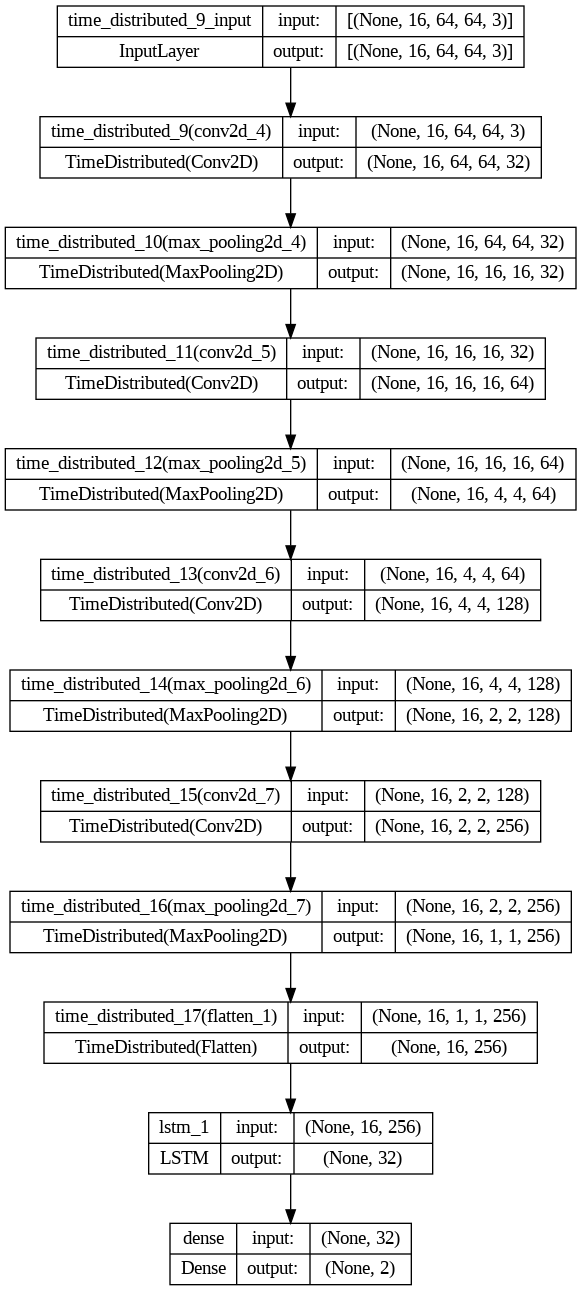

In [ ]:
plot_model(model, to_file = 'Suspicious_Human_Activity_LRCN_Model.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'accuracy', patience = 10, mode = 'max', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 15, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/15
338/338 [==============================] - 100s 282ms/step - loss: 0.6948 - accuracy: 0.5200 - val_loss: 0.6710 - val_accuracy: 0.5356
Epoch 2/15
338/338 [==============================] - 89s 263ms/step - loss: 0.6558 - accuracy: 0.6111 - val_loss: 0.6232 - val_accuracy: 0.6067
Epoch 3/15
338/338 [==============================] - 87s 259ms/step - loss: 0.5163 - accuracy: 0.7600 - val_loss: 0.4676 - val_accuracy: 0.7756
Epoch 4/15
338/338 [==============================] - 94s 277ms/step - loss: 0.4326 - accuracy: 0.8074 - val_loss: 0.4495 - val_accuracy: 0.8000
Epoch 5/15
338/338 [==============================] - 90s 265ms/step - loss: 0.3605 - accuracy: 0.8400 - val_loss: 0.3827 - val_accuracy: 0.8178
Epoch 6/15
338/338 [==============================] - 93s 276ms/step - loss: 0.3030 - accuracy: 0.8756 - val_loss: 0.3860 - val_accuracy: 0.8311
Epoch 7/15
338/338 [==============================] - 88s 259ms/step - loss: 0.2399 - accuracy: 0.9007 - val_loss: 0.3770 - val_a

In [ ]:
LRCN_model_history = model.evaluate(features_test, labels_test)

7/7 [==============================] - 5s 730ms/step - loss: 0.4724 - accuracy: 0.9000


In [ ]:
model.save("Suspicious_Human_Activity_Detection_LRCN_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

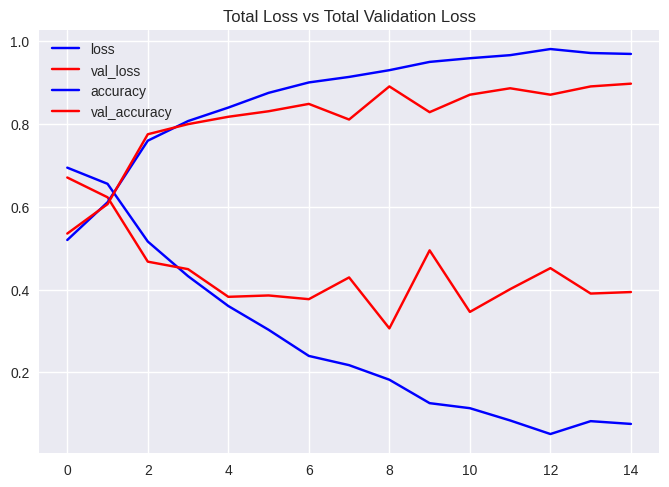

In [ ]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [ ]:
labels_predict = model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

7/7 [==============================] - 7s 937ms/step


[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

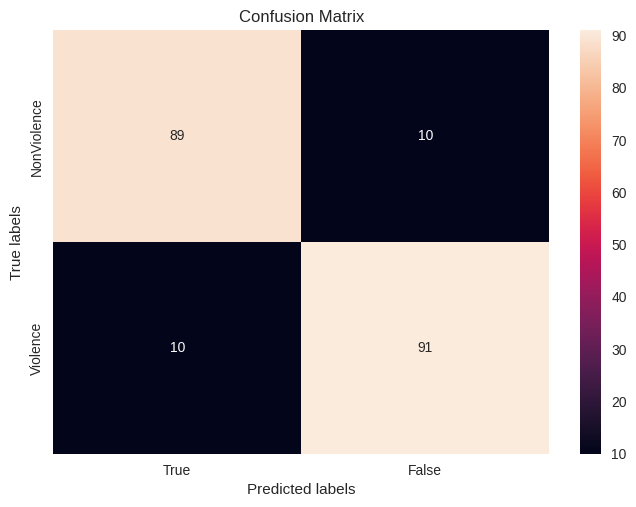

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

In [ ]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        if predicted_class_name == "Violence":
            cv2.putText(frame, 'Abnormal', (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, 'Normal', (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

plt.style.use("default")

In [ ]:
def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20, 15))
    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), 12))

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()

        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        ax.figure.set_size_inches(20, 20)
        plt.tight_layout()

    video_reader.release()

In [ ]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_list = []
    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis=0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [ ]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
from pytube import YouTube

In [ ]:
def predict_video_from_url(video_url, sequence_length=16):
    try:
        # Get YouTube video details using pytube
        youtube_video = YouTube(video_url)
        video_stream = youtube_video.streams.filter(file_extension="mp4").first()
        video_stream_url = video_stream.url
        predict_frames(video_stream_url, output_video_file_path, sequence_length)
        show_pred_frames(output_video_file_path)


        # Perform prediction on the video
        predict_video(video_stream_url, sequence_length)

    except Exception as e:
        print(f"Error: {e}")

1/1 [==============================] - 0s 43ms/step
Predicted: NonViolence
Confidence: 0.6706234216690063


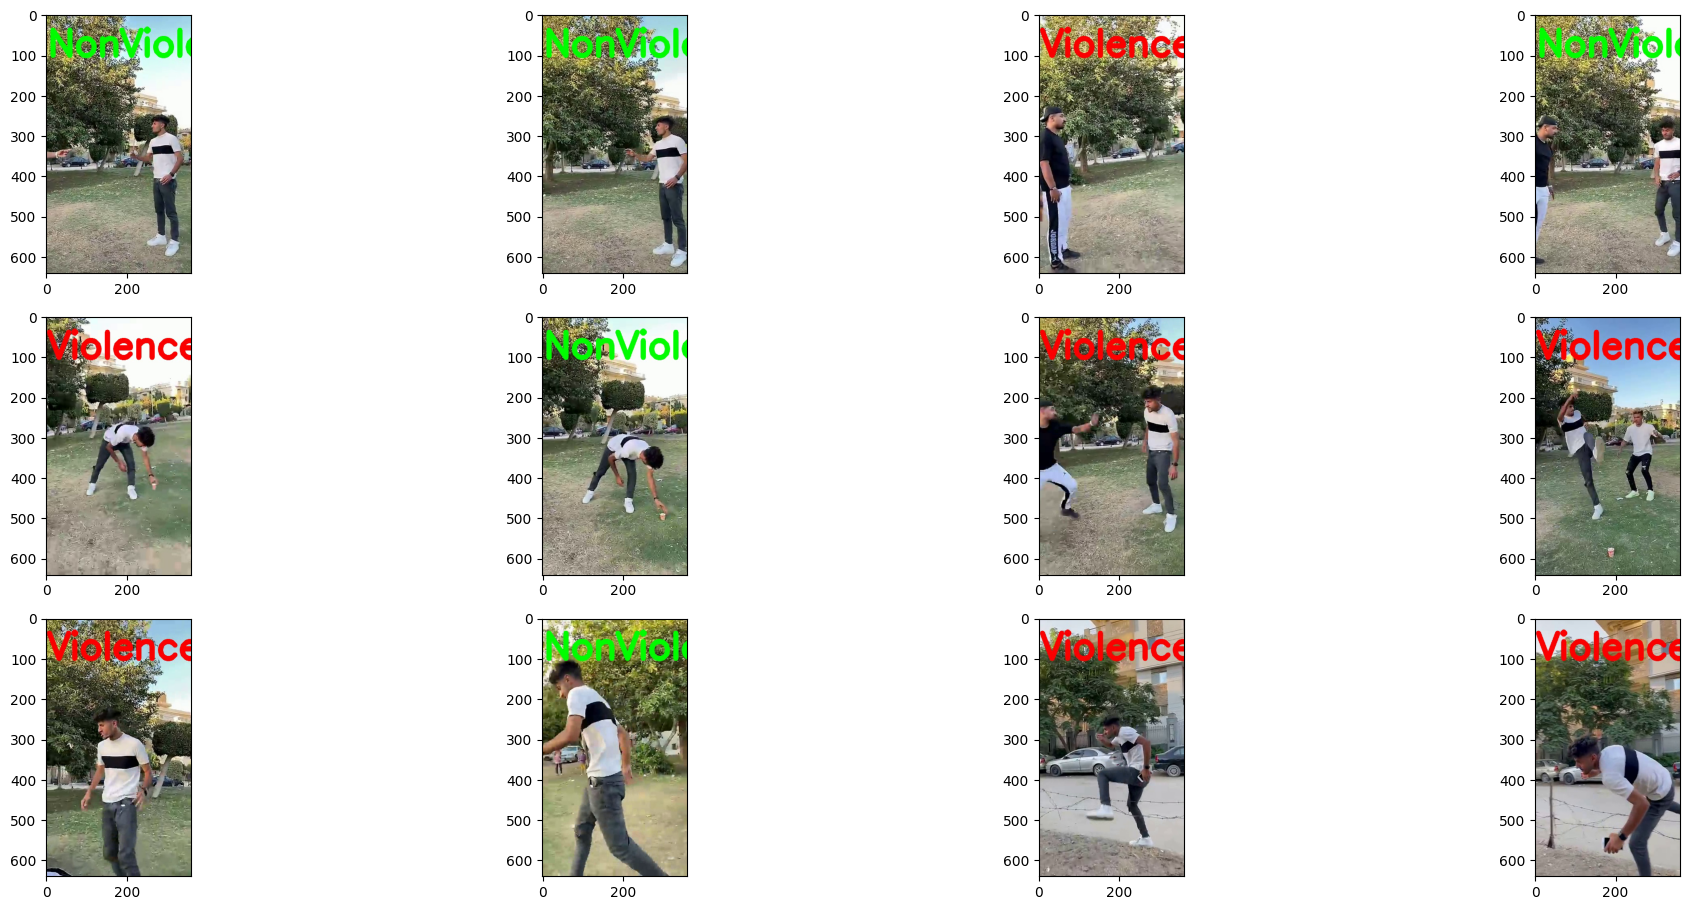

In [ ]:
user_video_url ="https://youtube.com/shorts/f4WsfLQF6VY?si=Y8xE9xoNM7hhIwXo"
predict_video_from_url(user_video_url)

In [ ]:
import pickle


In [ ]:
with open('/content/drive/MyDrive/LRCNMODEL', 'wb') as f:
    pickle.dump(model, f)

// MOVIENet V2

In [ ]:
mobilenet = MobileNetV2(include_top=False, weights="imagenet")
mobilenet.trainable = True

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
for layer in mobilenet.layers[:-40]:
    layer.trainable = False

In [ ]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeD  (None, 16, 2, 2, 1280)    2257984   
 istributed)                                                     
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_19 (TimeD  (None, 16, 5120)          0         
 istributed)                                                     
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

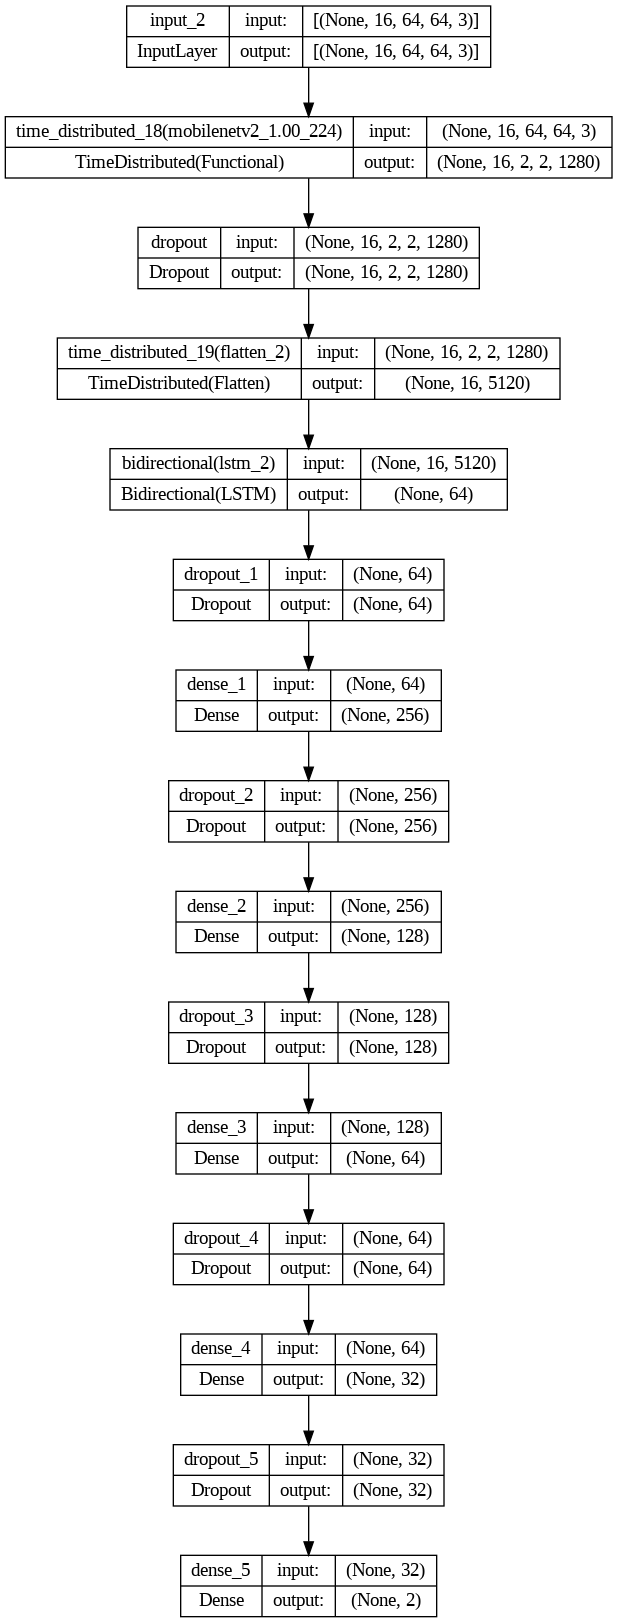

In [ ]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

In [ ]:
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])
MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=40, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[early_stopping_callback, reduce_lr])

Epoch 1/40
180/180 [==============================] - 257s 1s/step - loss: 0.6938 - accuracy: 0.5118 - val_loss: 0.6943 - val_accuracy: 0.4861 - lr: 0.0100
Epoch 2/40
180/180 [==============================] - 246s 1s/step - loss: 0.6851 - accuracy: 0.5403 - val_loss: 0.6861 - val_accuracy: 0.4806 - lr: 0.0100
Epoch 3/40
180/180 [==============================] - 251s 1s/step - loss: 0.6608 - accuracy: 0.5910 - val_loss: 0.6415 - val_accuracy: 0.6278 - lr: 0.0100
Epoch 4/40
180/180 [==============================] - 247s 1s/step - loss: 0.5772 - accuracy: 0.7104 - val_loss: 0.4844 - val_accuracy: 0.8111 - lr: 0.0100
Epoch 5/40
180/180 [==============================] - 250s 1s/step - loss: 0.4746 - accuracy: 0.7882 - val_loss: 0.4369 - val_accuracy: 0.7889 - lr: 0.0100
Epoch 6/40
180/180 [==============================] - 243s 1s/step - loss: 0.3403 - accuracy: 0.8771 - val_loss: 0.8682 - val_accuracy: 0.7389 - lr: 0.0100
Epoch 7/40
180/180 [==============================] - 250s 1s/st

In [ ]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 20s 2s/step - loss: 0.3044 - accuracy: 0.9200


In [ ]:
MoBiLSTM_model.save("Violance_Detection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

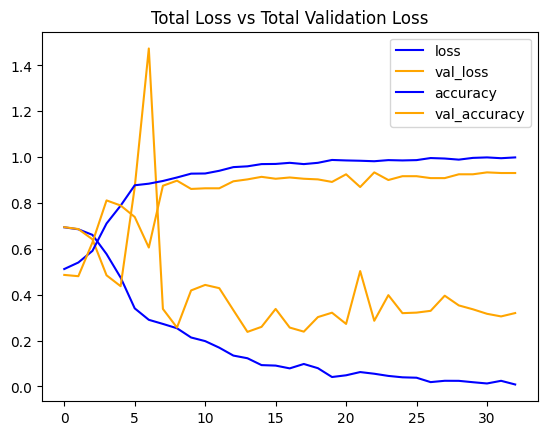

In [ ]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [ ]:
labels_predict = MoBiLSTM_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

7/7 [==============================] - 17s 2s/step


In [ ]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.92


[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

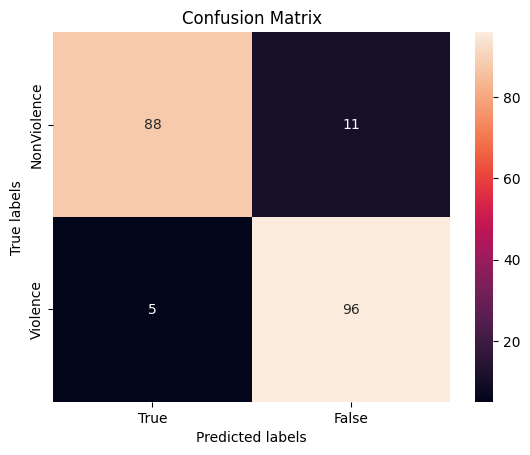

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels_test_normal, labels_predict, target_names=['NonViolence', 'Violence'])

# Print the report
print(report)


              precision    recall  f1-score   support

 NonViolence       0.95      0.89      0.92        99
    Violence       0.90      0.95      0.92       101

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



//UNet Model

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels_test_normal, labels_predict, target_names=['NonViolence', 'Violence'], output_dict=True)

# Extract precision and recall for each class
precision_nonviolence = report['NonViolence']['precision']
recall_nonviolence = report['NonViolence']['recall']

precision_violence = report['Violence']['precision']
recall_violence = report['Violence']['recall']

print("NonViolence Precision:", precision_nonviolence)
print("NonViolence Recall:", recall_nonviolence)

print("Violence Precision:", precision_violence)
print("Violence Recall:", recall_violence)


NonViolence Precision: 0.946236559139785
NonViolence Recall: 0.8888888888888888
Violence Precision: 0.897196261682243
Violence Recall: 0.9504950495049505


In [ ]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        if predicted_class_name == "Violence":
            cv2.putText(frame, 'Abnormal', (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, 'Normal', (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

plt.style.use("default")

In [ ]:
def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20, 15))
    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), 12))

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()

        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        ax.figure.set_size_inches(20, 20)
        plt.tight_layout()

    video_reader.release()

In [ ]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_list = []
    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis=0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [ ]:
def predict_video_from_url(video_url, sequence_length=16):
    try:
        # Get YouTube video details using pytube
        youtube_video = YouTube(video_url)
        video_stream = youtube_video.streams.filter(file_extension="mp4").first()
        video_stream_url = video_stream.url
        predict_frames(video_stream_url, output_video_file_path, sequence_length)
        show_pred_frames(output_video_file_path)


        # Perform prediction on the video
        predict_video(video_stream_url, sequence_length)

    except Exception as e:
        print(f"Error: {e}")

1/1 [==============================] - 0s 83ms/step
Predicted: Violence
Confidence: 0.9993079900741577


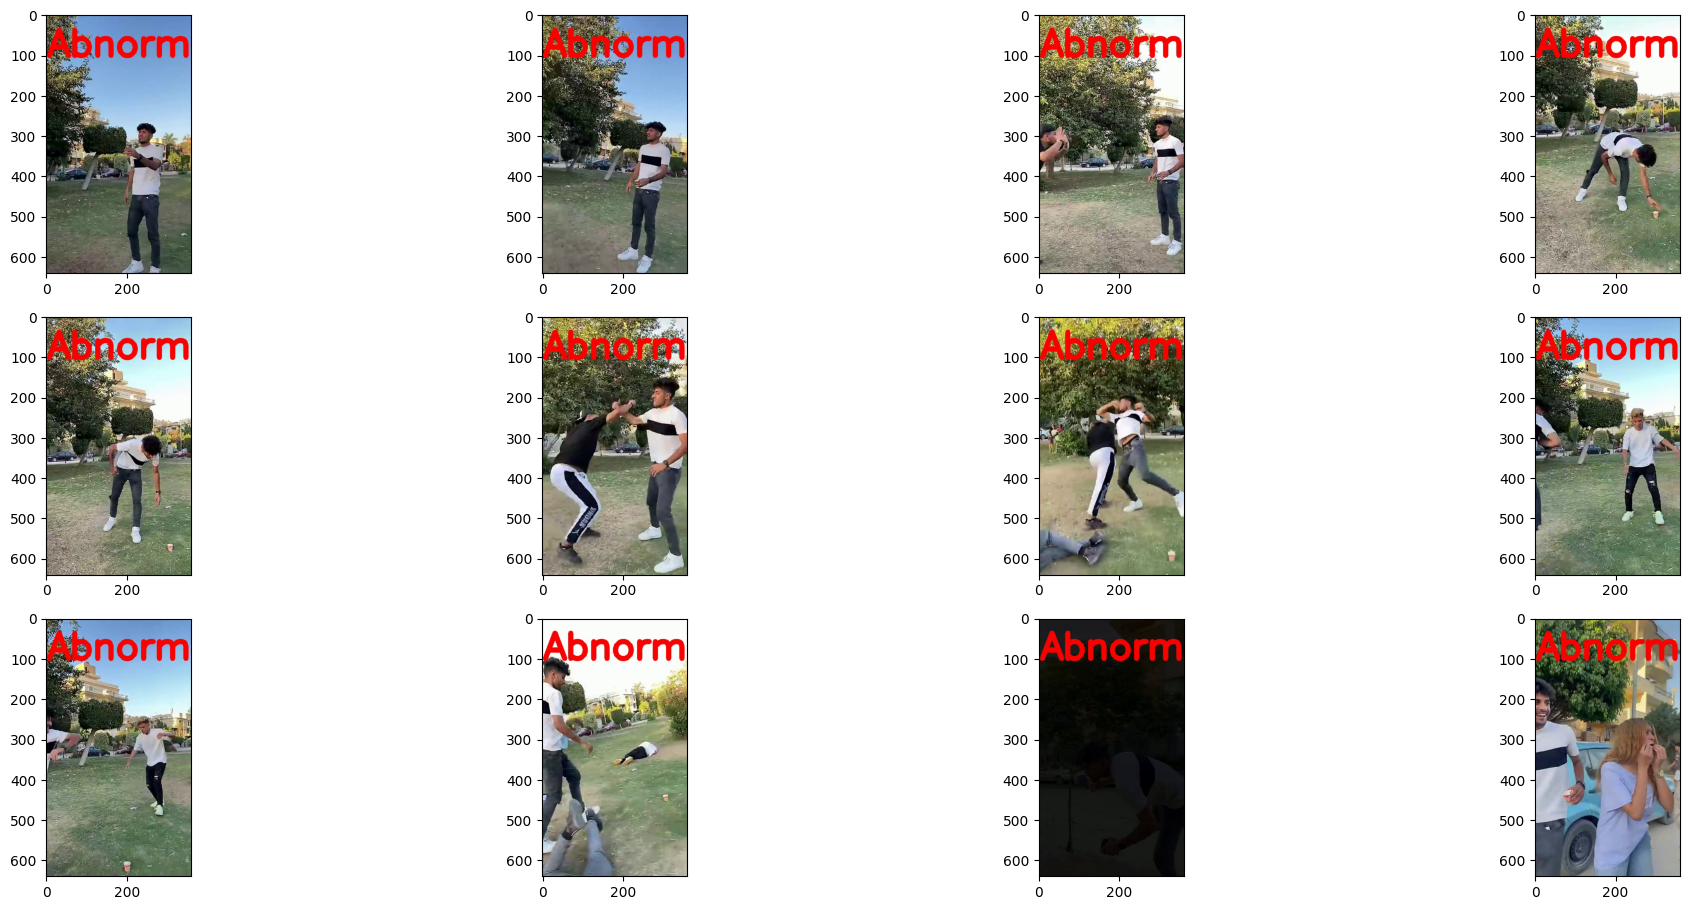

In [ ]:
user_video_url ="https://youtube.com/shorts/f4WsfLQF6VY?si=Y8xE9xoNM7hhIwXo"
predict_video_from_url(user_video_url)

In [ ]:
with open('/content/drive/MyDrive/MOBILENETV2MODEL', 'wb') as f:
    pickle.dump(MoBiLSTM_model, f)

//UNET MODEL


In [ ]:
plot_model(model, to_file = 'UNET_Model.png', show_shapes = True, show_layer_names = True)